In [1]:
%matplotlib inline
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
from utils import RESULTS_ROOT

ORDERED_FOLDERS = [
    "20211108_4microstates_2.0-20.0Hz_EO_subjectwise",
    "20211109_FTsurrs_4microstates_2.0-20.0Hz_EO_subjectwise",
    "20211109_AAFTsurrs_4microstates_2.0-20.0Hz_EO_subjectwise",
    "20211110_IAAFTsurrs_4microstates_2.0-20.0Hz_EO_subjectwise",
    "20211109_SHUFFLEsurrs_4microstates_2.0-20.0Hz_EO_subjectwise",
    "20211108_4PCA_2.0-20.0Hz_EO_subjectwise",
    "20211109_FTsurrs_4PCA_2.0-20.0Hz_EO_subjectwise",
    "20211109_AAFTsurrs_4PCA_2.0-20.0Hz_EO_subjectwise",
    "20211110_IAAFTsurrs_4PCA_2.0-20.0Hz_EO_subjectwise",
    "20211110_SHUFFLEsurrs_4PCA_2.0-20.0Hz_EO_subjectwise",
    "20211109_4ICA_2.0-20.0Hz_EO_subjectwise",
    "20211110_FTsurrs_4ICA_2.0-20.0Hz_EO_subjectwise",
    "20211110_AAFTsurrs_4ICA_2.0-20.0Hz_EO_subjectwise",
    "20211110_IAAFTsurrs_4ICA_2.0-20.0Hz_EO_subjectwise",
    "20211110_SHUFFLEsurrs_4ICA_2.0-20.0Hz_EO_subjectwise",
    "20211112_4hmm_2.0-20.0Hz_EO_subjectwise",
    "20211110_FTsurrs_4hmm_2.0-20.0Hz_EO_subjectwise",
    "20211110_AAFTsurrs_4hmm_2.0-20.0Hz_EO_subjectwise",
    "20211110_IAAFTsurrs_4hmm_2.0-20.0Hz_EO_subjectwise",
    "20211110_SHUFFLEsurrs_4hmm_2.0-20.0Hz_EO_subjectwise",
]

In [2]:
def plot_matrix_w_annot(array, annot=True, mask_pvals=False, title=""):
    plt.figure(figsize=(12, 10))
    if annot and array.ndim == 3:
        annot = np.tril(array[..., 0], k=-1)
        annot += np.triu(array[..., 1], k=1)
        annot[np.eye(annot.shape[0], dtype=bool)] = np.nan
        mask = np.isnan(annot)
    else:
        mask = np.zeros((array.shape[0], array.shape[1]), dtype=bool)
    plot_array = array if array.ndim == 2 else array[..., 0]
    if mask_pvals:
        mask = np.logical_or(array[..., 1] > 0.05, mask)
    sns.heatmap(
        plot_array,
        square=True,
        annot=annot,
        mask=mask,
        fmt=".2f",
        annot_kws={"size": 9},
    )
    for line in np.arange(5, array.shape[0], 5):
        plt.axhline(line, color="w")
        plt.axvline(line, color="w")
    xlims = plt.gca().get_xlim()
    ylims = plt.gca().get_ylim()
    plt.plot(
        [xlims[0], xlims[1]],
        [ylims[1], ylims[0]],
        "--",
        color=plt.rcParams["text.color"],
        linewidth=1.0,
    )
    _ = plt.yticks(
        ticks=np.arange(20) + 0.5,
        labels=["data", "FT", "AAFT", "IAAFT", "shuffle"] * 4,
        rotation=0,
    )
    _ = plt.xticks(
        ticks=np.arange(20) + 0.5,
        labels=["data", "FT", "AAFT", "IAAFT", "shuffle"] * 4,
        rotation=90,
    )
    for pos, method in enumerate(["microstates", "PCA", "ICA", "HMM"]):
        plt.text(
            -4, 2.5 + 5 * pos, method, size=20, ha="left", rotation=90, va="center"
        )
        plt.text(2.5 + 5 * pos, 24, method, size=20, ha="center")
    plt.title(title)

In [3]:
all_dfs = []
for fold in ORDERED_FOLDERS:
    df = pd.read_csv(os.path.join(RESULTS_ROOT, fold, "latent_stats.csv"), index_col=0)
    all_dfs.append(df)

In [4]:
state_names = ["all", "A", "B", "C", "D"]
variables = ["coverage", "occurrence", "lifespan"]

t_stats = np.zeros(
    (len(variables), len(state_names), len(ORDERED_FOLDERS), len(ORDERED_FOLDERS), 2)
)
for i in range(len(ORDERED_FOLDERS)):
    for j in range(len(ORDERED_FOLDERS)):
        df1 = all_dfs[i]
        df2 = all_dfs[j]
        for k, var in enumerate(variables):
            for ms in range(len(state_names)):
                state_n = state_names[ms]
                if state_n == "all":
                    ttest = pg.ttest(
                        df1[var],
                        df2[var],
                    )
                else:
                    ttest = pg.ttest(
                        df1[df1["latent map"] == state_n][var],
                        df2[df2["latent map"] == state_n][var],
                    )
                t_stats[k, ms, i, j, 0] = ttest.loc["T-test", "T"]
                t_stats[k, ms, i, j, 1] = ttest.loc["T-test", "p-val"]

/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/bayesian.py:146: RuntimeWarning: divide by zero encountered in double_scalars
  bf10 = 1 / ((1 + t**2 / df)**(-(df + 1) / 2) / integr)


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/seaborn/matrix.py:198: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/seaborn/matrix.py:203: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


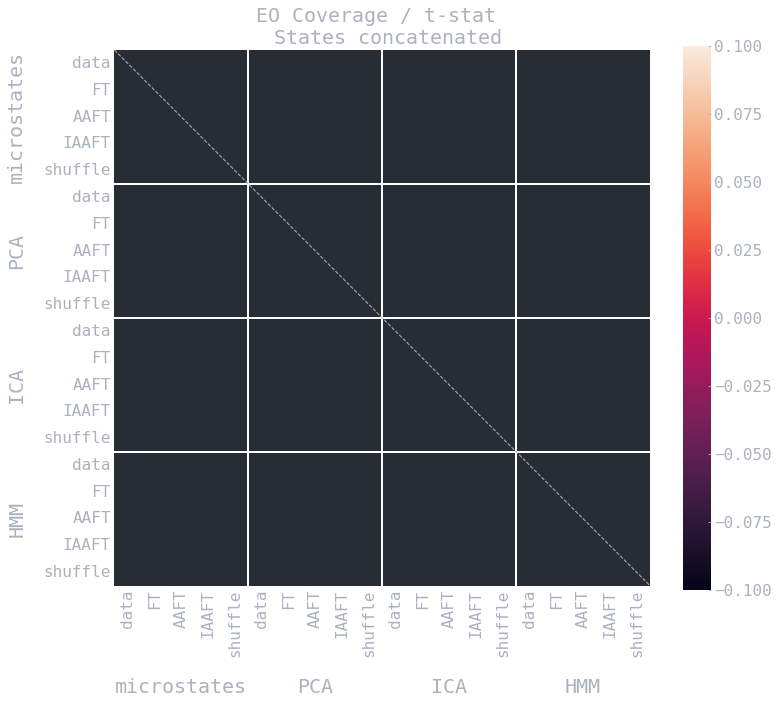

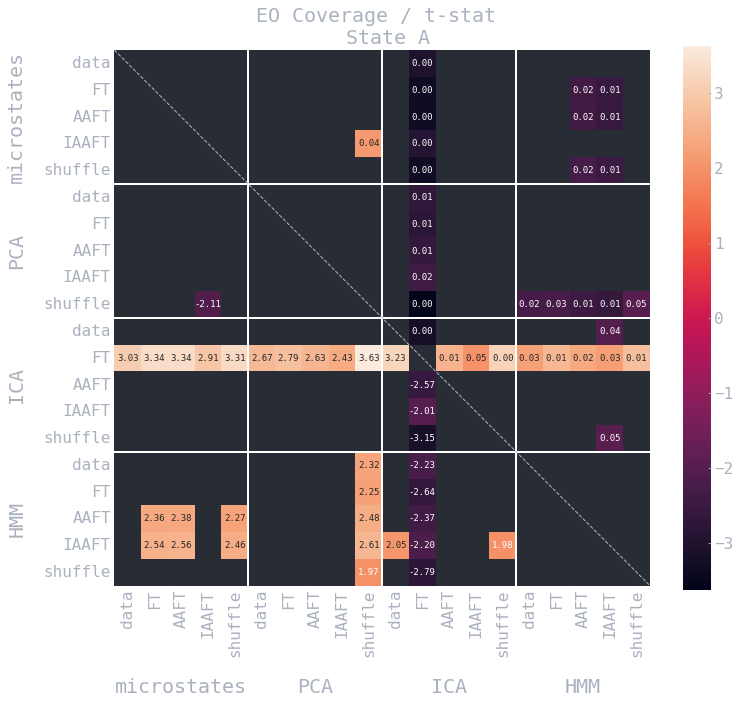

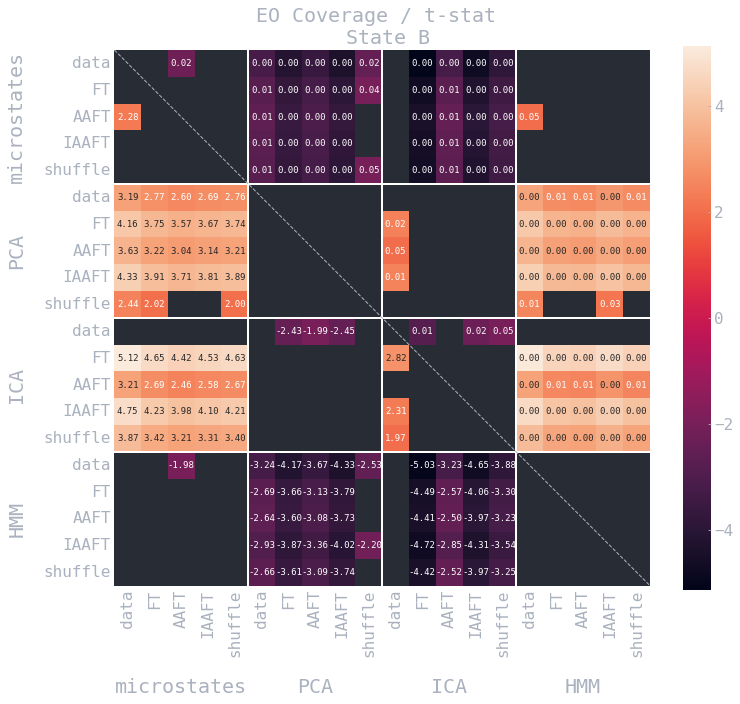

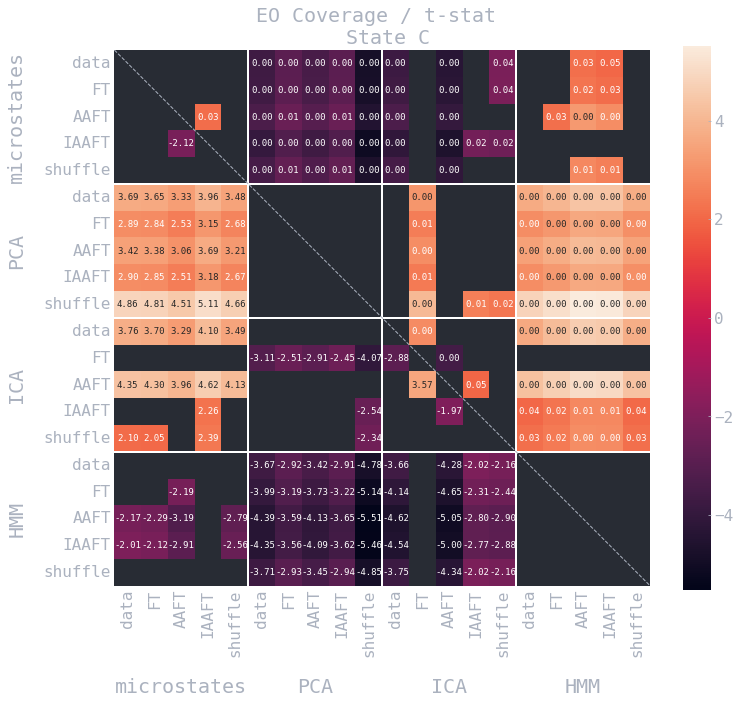

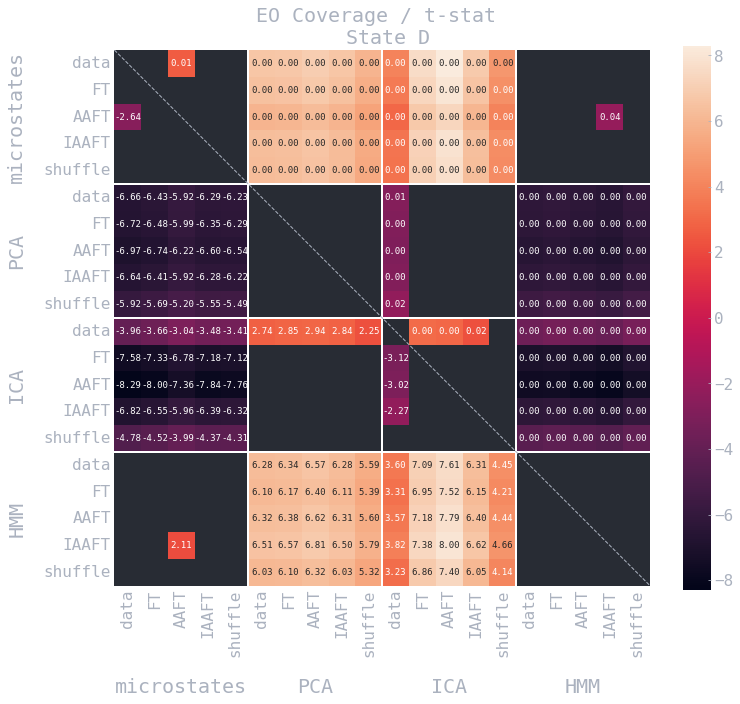

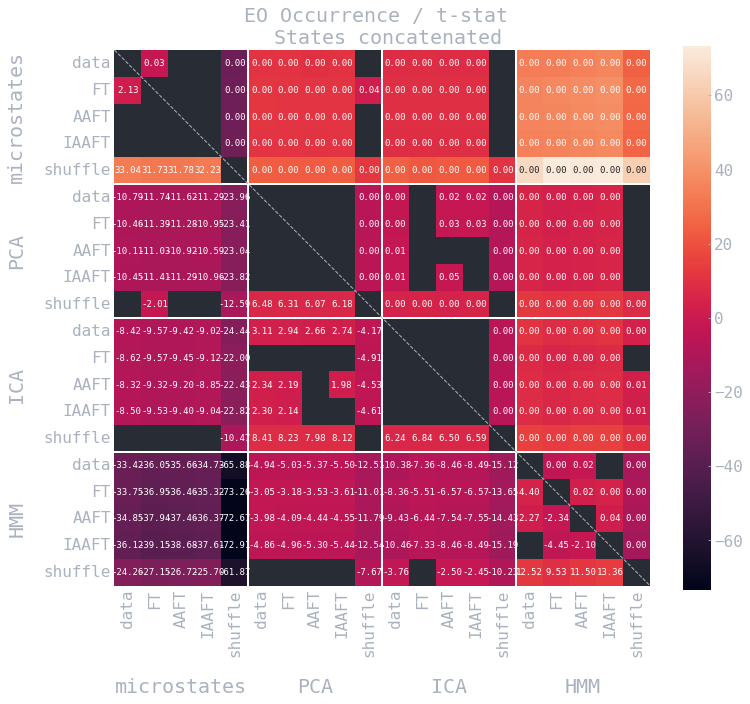

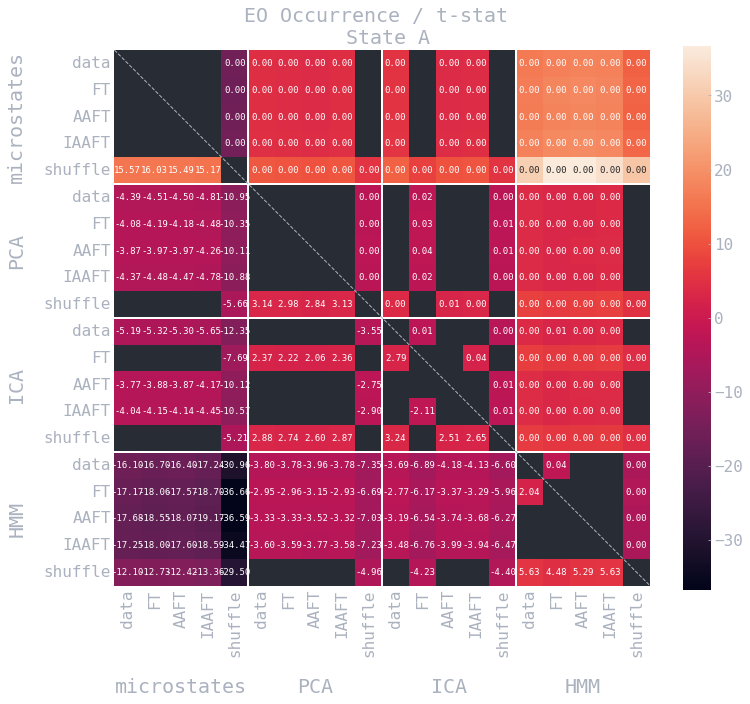

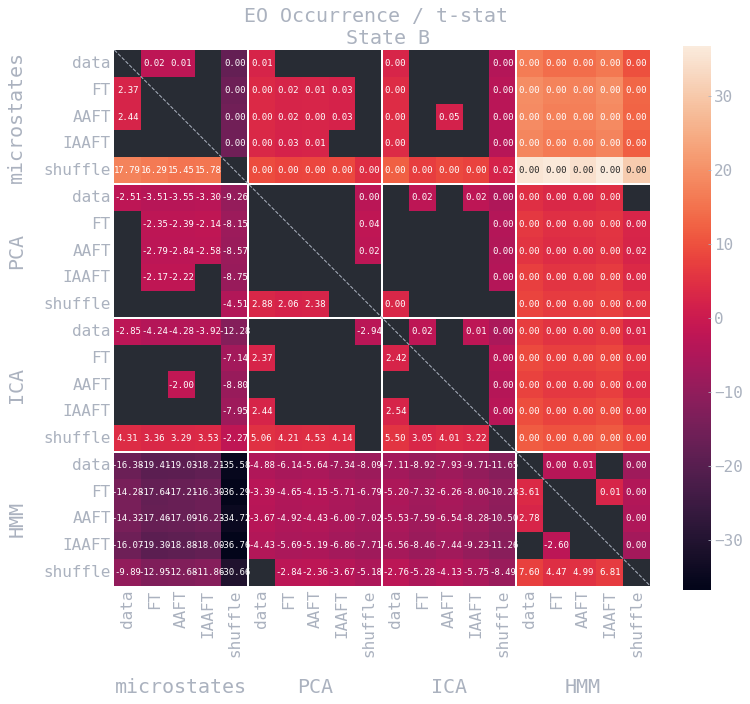

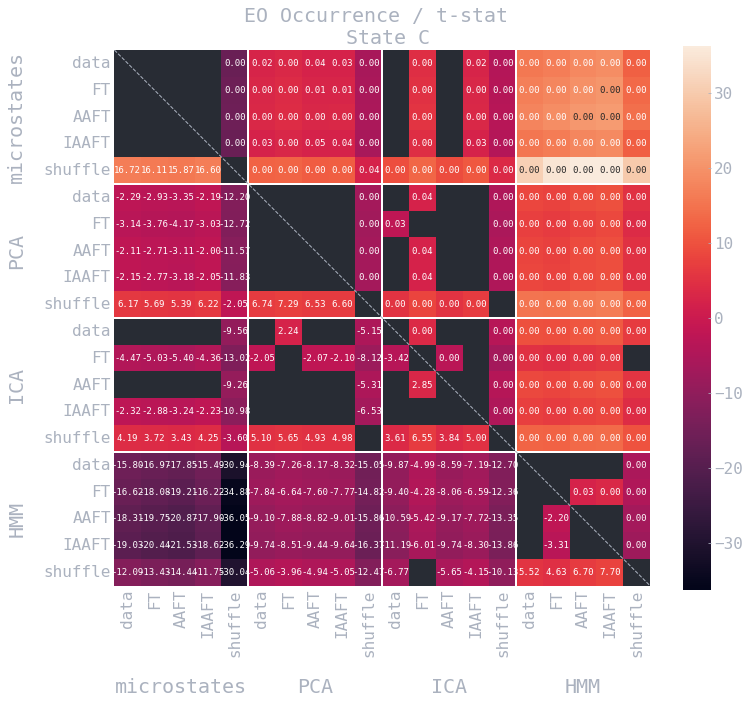

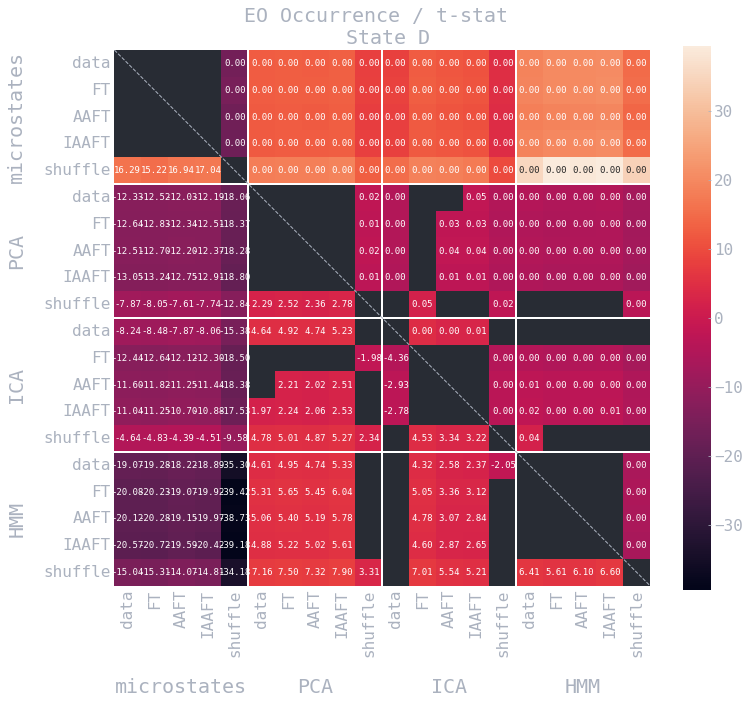

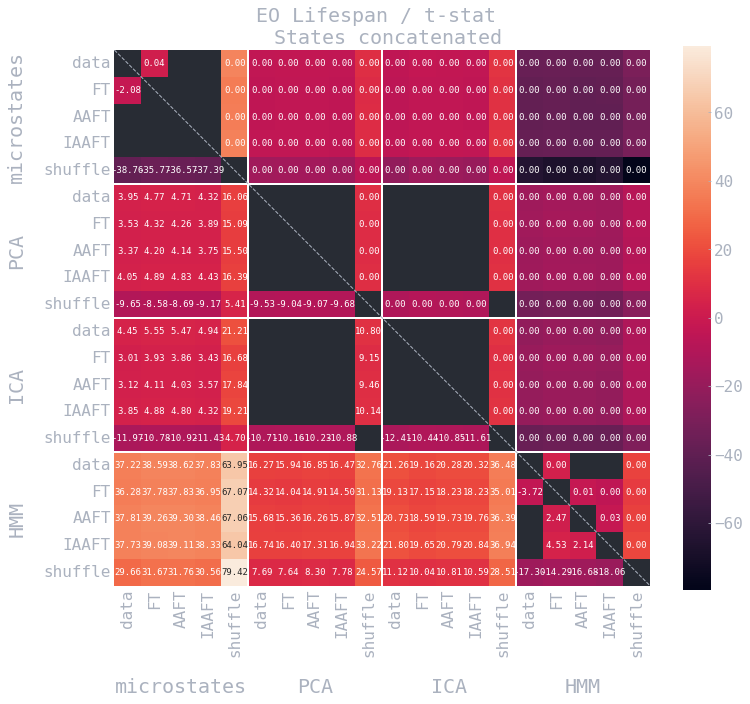

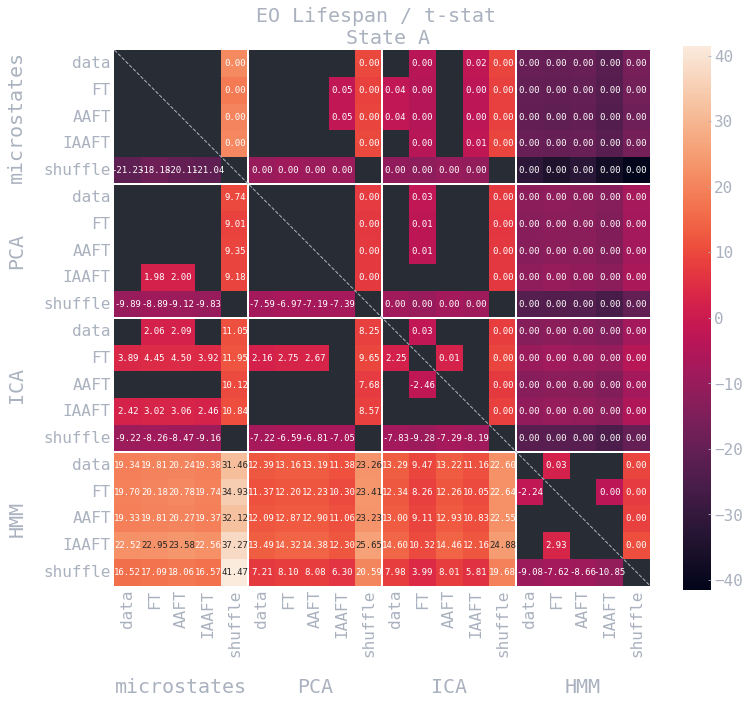

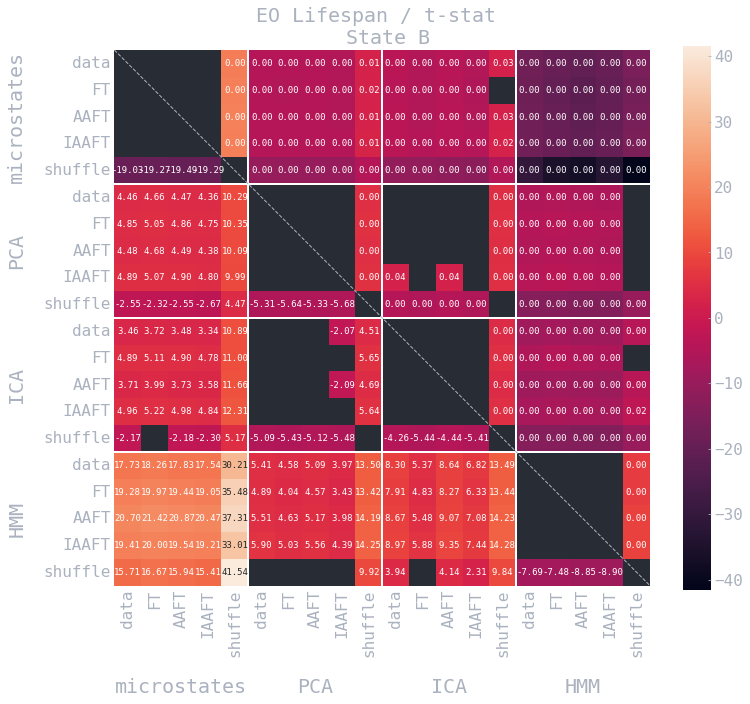

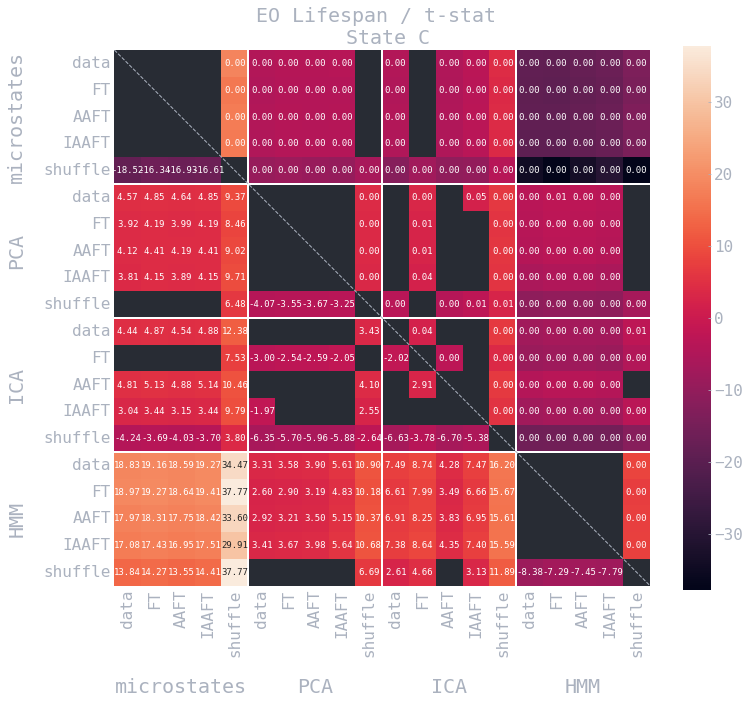

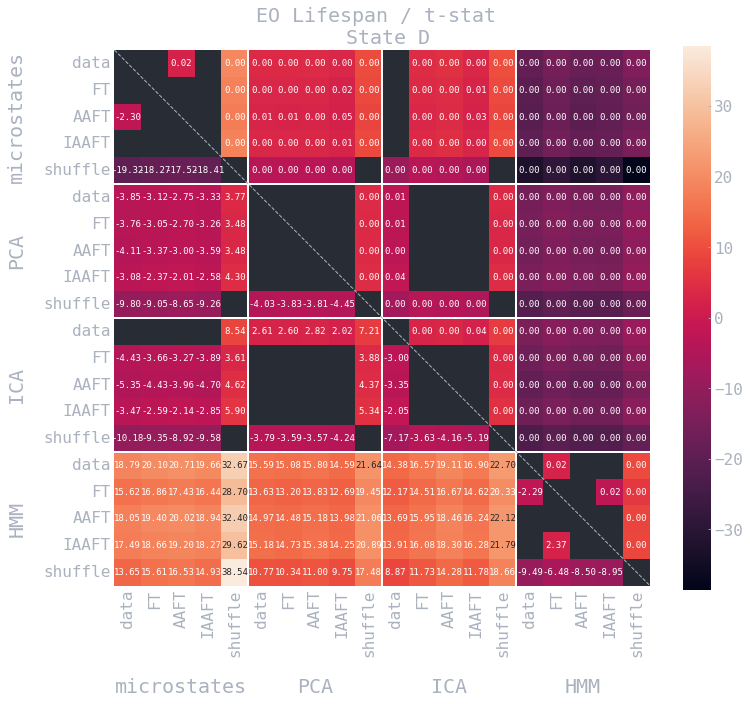

In [5]:
for k, var in enumerate(variables):
    for ms in range(len(state_names)):
        if state_names[ms] == "all":
            tit = f"EO {var.title()} / t-stat \n States concatenated"
        else:
            tit = f"EO {var.title()} / t-stat \n State {state_names[ms]}"
        plot_matrix_w_annot(
            t_stats[k, ms, ...],
            annot=True,
            mask_pvals=True,
            title=tit,
        )

In [6]:
# build transition mats
all_trans_mats = []
for df in all_dfs:
    trans_mats = {}
    for i, df2 in df.groupby(["subject_id"]):
        df2 = df2.sort_values(by="latent map")
        temp = df2.filter(like="transition").values
        assert temp.shape == (4, 4)
        np.testing.assert_allclose(temp.sum(axis=1), 1.0)
        trans_mats[i] = temp
    all_trans_mats.append(trans_mats)

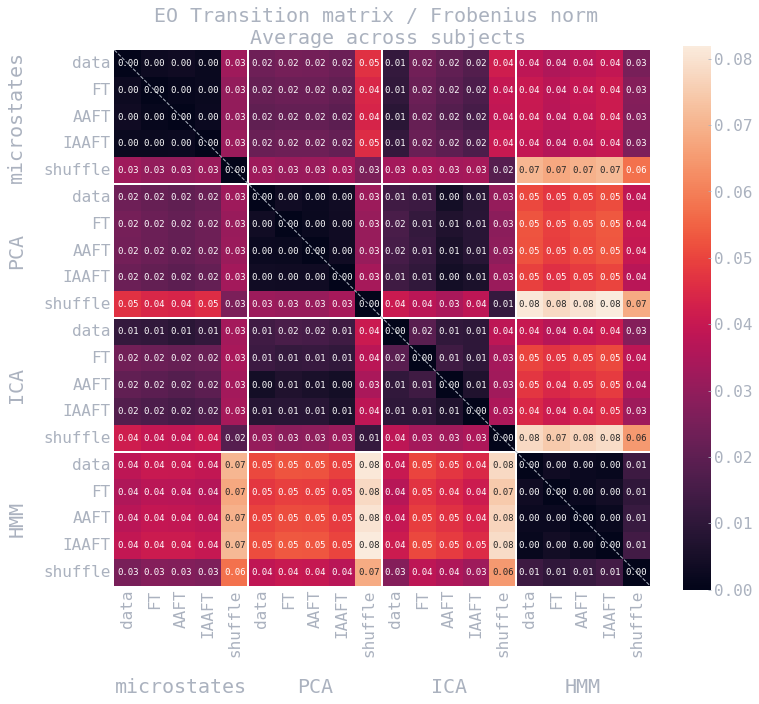

In [7]:
norm_trans_mats = np.zeros((len(ORDERED_FOLDERS), len(ORDERED_FOLDERS)))

for i in range(len(ORDERED_FOLDERS)):
    for j in range(len(ORDERED_FOLDERS)):
        mat_1 = np.array(list(all_trans_mats[i].values())).mean(axis=0)
        mat_2 = np.array(list(all_trans_mats[j].values())).mean(axis=0)
        norm_trans_mats[i, j] = np.linalg.norm(mat_1 - mat_2)

plot_matrix_w_annot(
    norm_trans_mats,
    annot=True,
    mask_pvals=False,
    title="EO Transition matrix / Frobenius norm \n Average across subjects",
)

Text(0.5, 0.98, 'EO Microstates')

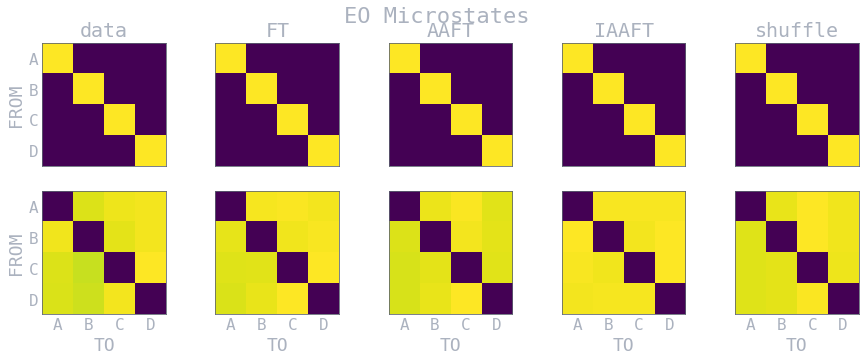

In [8]:
_, axs = plt.subplots(ncols=5, nrows=2, sharex=True, sharey=True, figsize=(15, 5))
data_types = ["data", "FT", "AAFT", "IAAFT", "shuffle"]

for i in range(5):
    mat = np.array(list(all_trans_mats[i].values())).mean(axis=0)
    axs[0, i].imshow(mat)
    mat[np.eye(mat.shape[0],dtype=bool)] = 0.0
    axs[1, i].imshow(mat)
    axs[0, i].set_title(data_types[i])
    
for ax in axs[:, 0]:
    ax.set_yticks(np.arange(4))
    ax.set_yticklabels(["A", "B", "C", "D"])
    ax.set_ylabel("FROM")
    
for ax in axs[-1, :]:
    ax.set_xticks(np.arange(4))
    ax.set_xticklabels(["A", "B", "C", "D"])
    ax.set_xlabel("TO")
    
plt.suptitle("EO Microstates")

In [9]:
state_names = ["A", "B", "C", "D"]
variables = ["transition->A", "transition->B", "transition->C", "transition->D"]

t_stats_trans = np.zeros(
    (len(variables), len(state_names), len(ORDERED_FOLDERS), len(ORDERED_FOLDERS), 2)
)
for i in range(len(ORDERED_FOLDERS)):
    for j in range(len(ORDERED_FOLDERS)):
        df1 = all_dfs[i]
        df2 = all_dfs[j]
        for k, var in enumerate(variables):
            for ms in range(len(state_names)):
                state_n = state_names[ms]
                ttest = pg.ttest(
                    df1[df1["latent map"] == state_n][var],
                    df2[df2["latent map"] == state_n][var],
                )
                t_stats_trans[k, ms, i, j, 0] = ttest.loc["T-test", "T"]
                t_stats_trans[k, ms, i, j, 1] = ttest.loc["T-test", "p-val"]

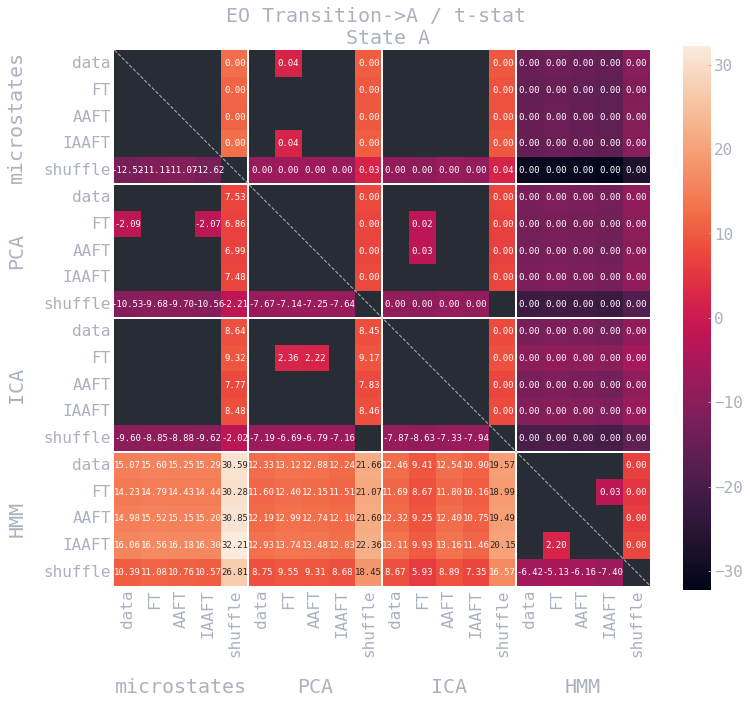

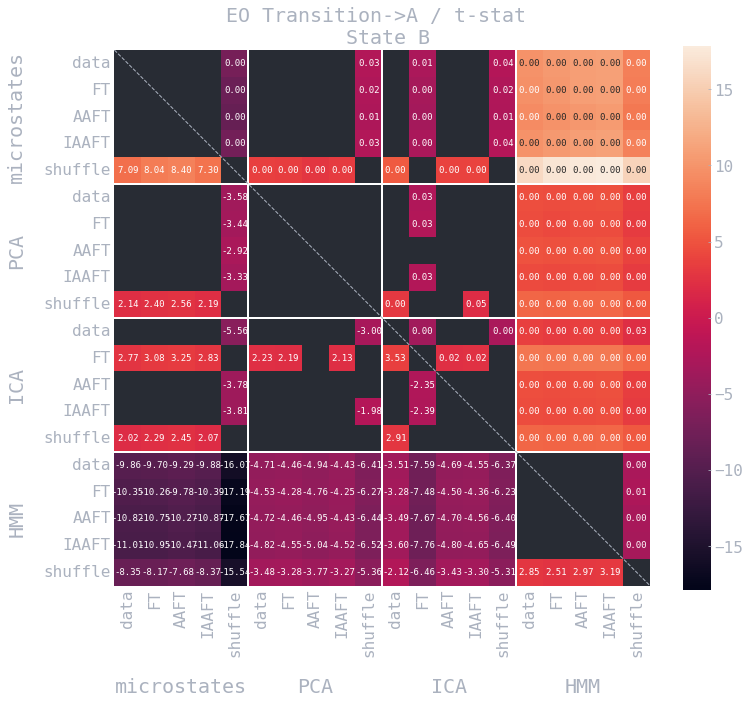

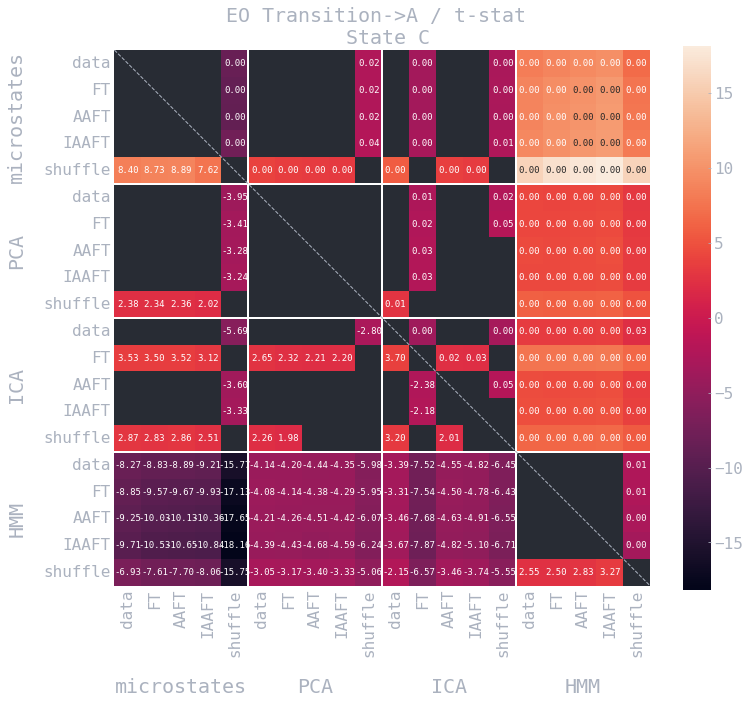

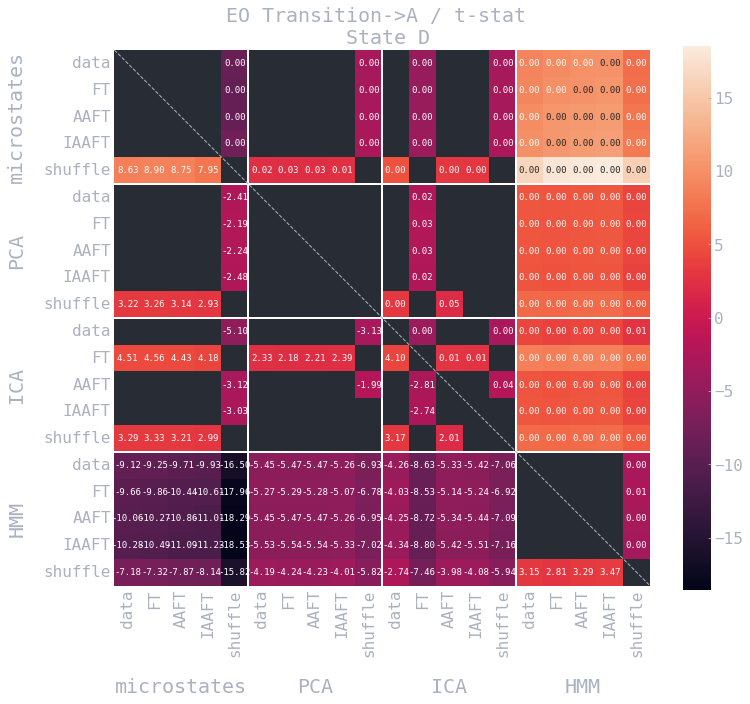

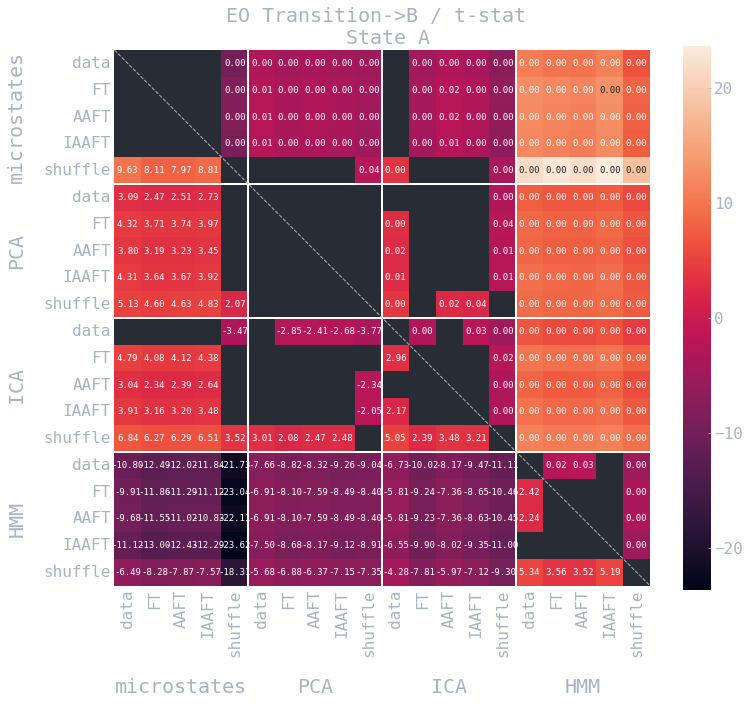

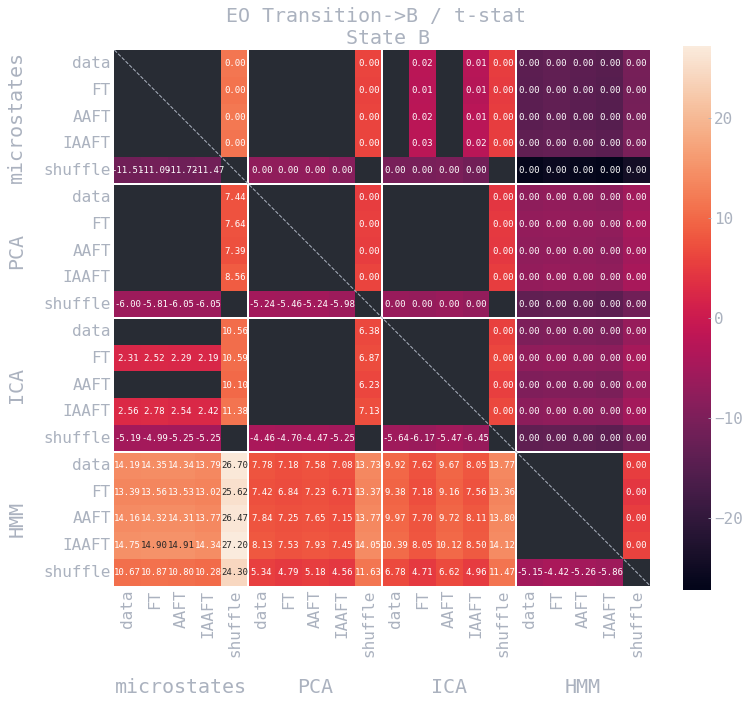

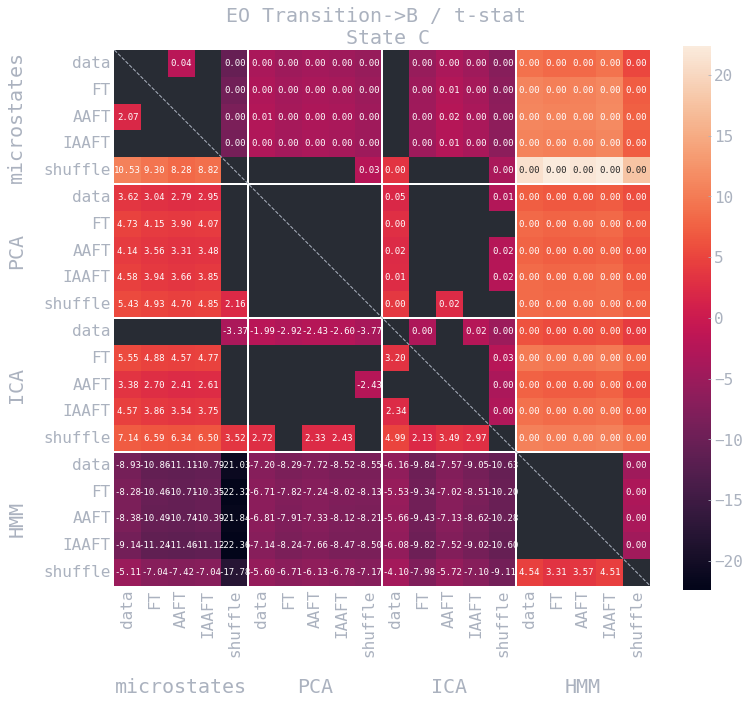

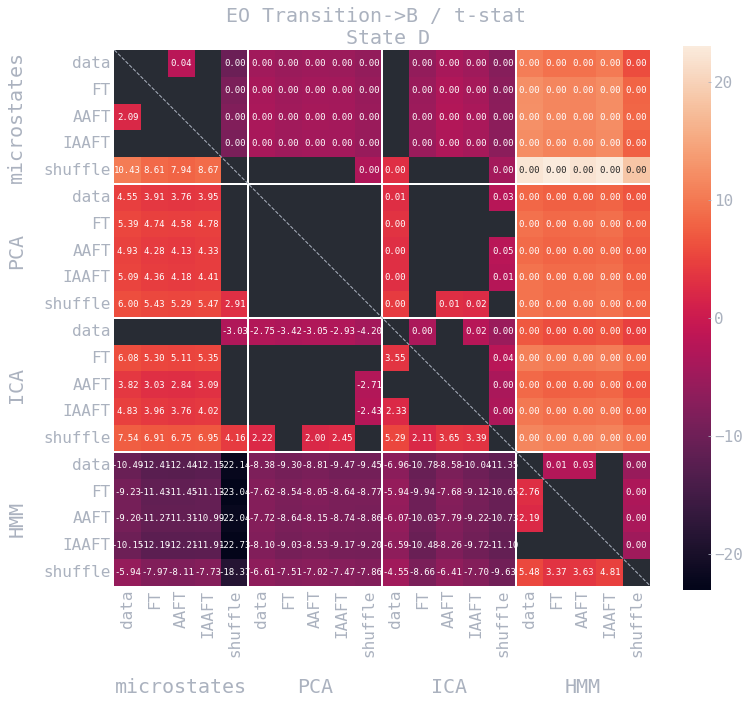

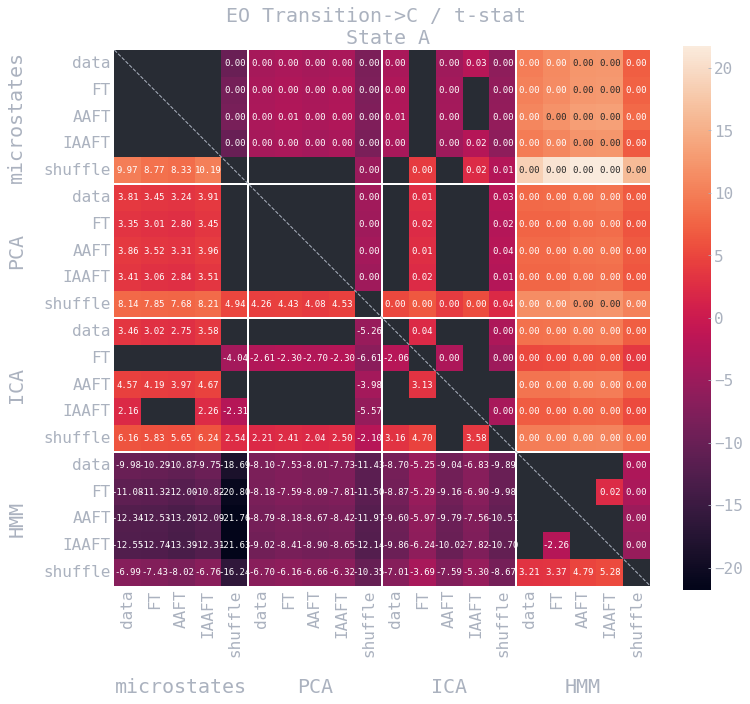

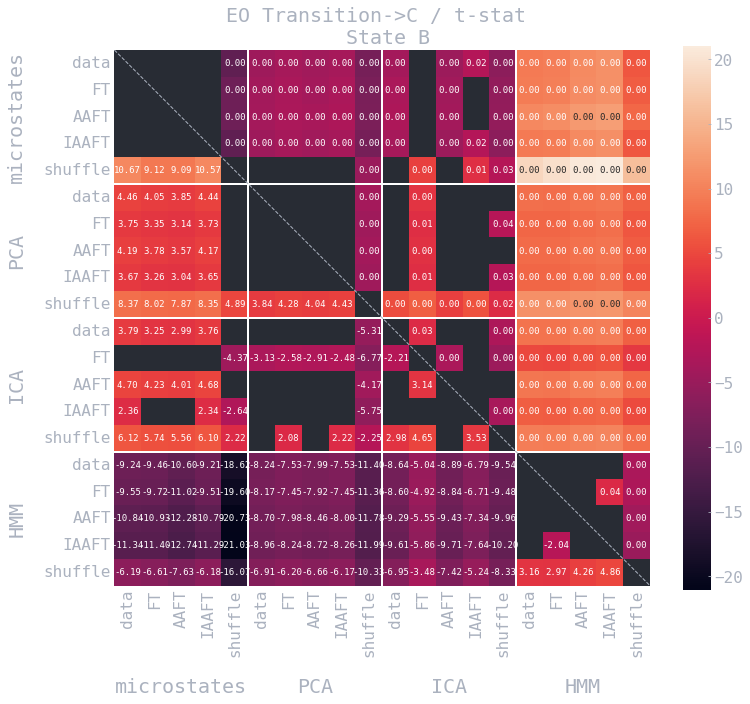

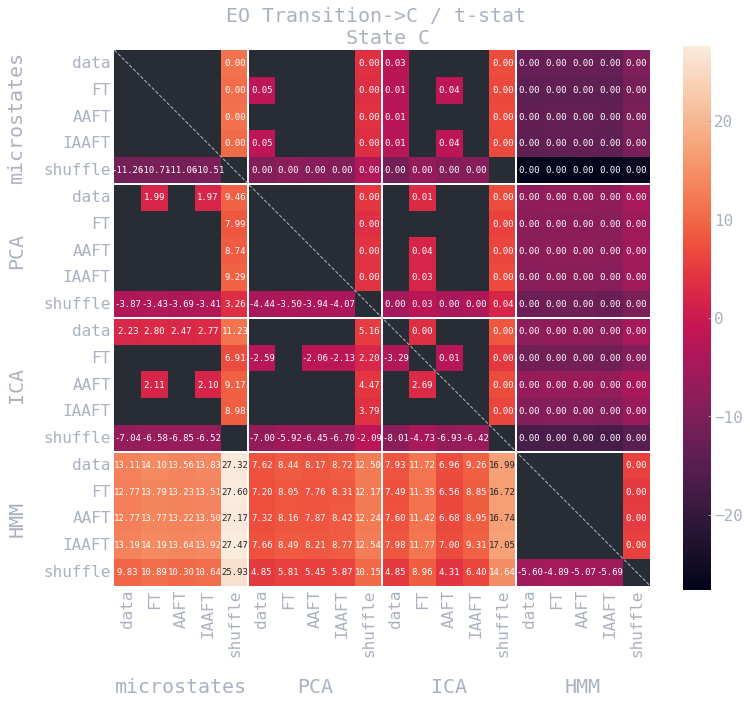

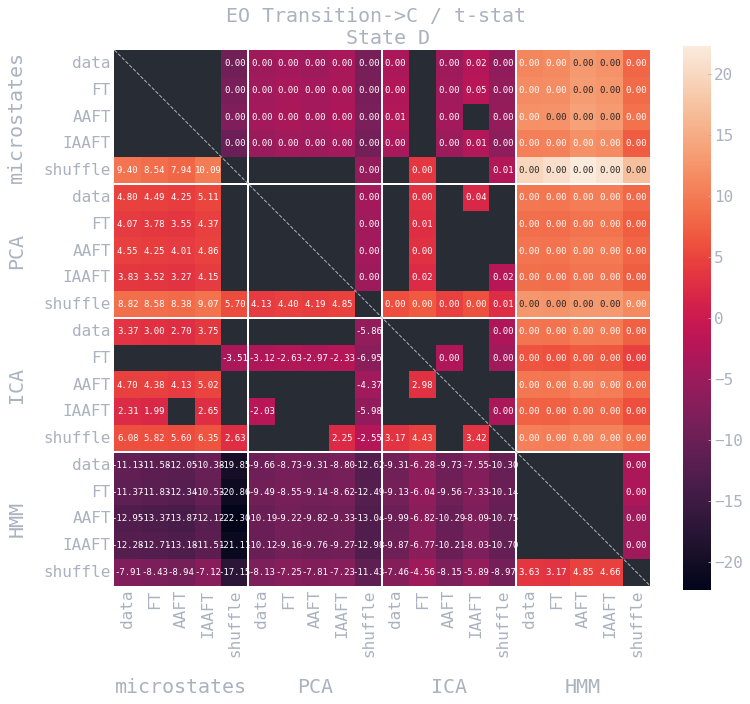

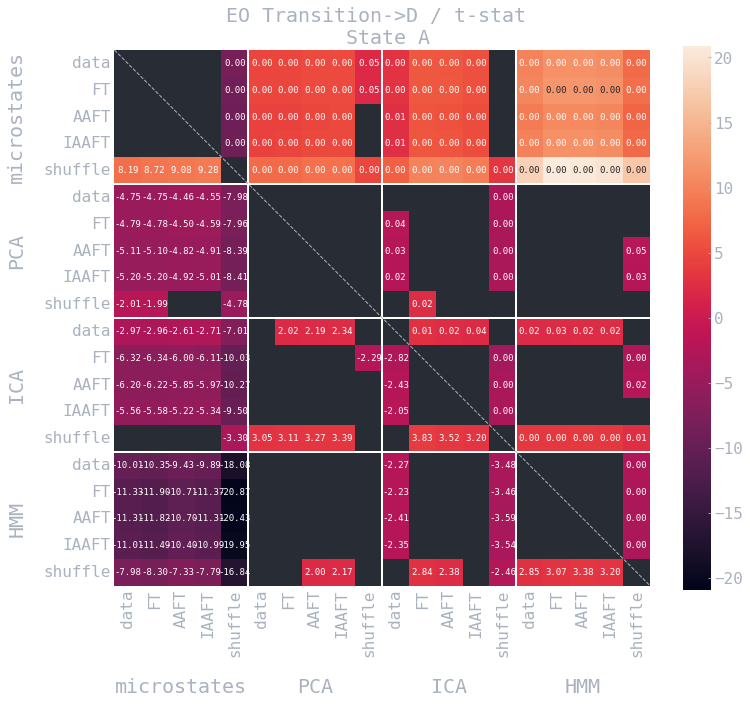

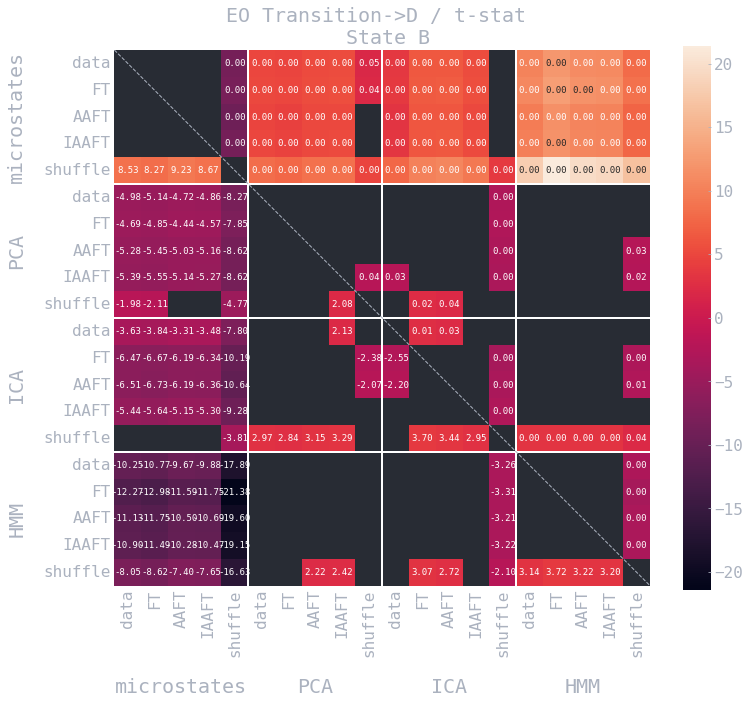

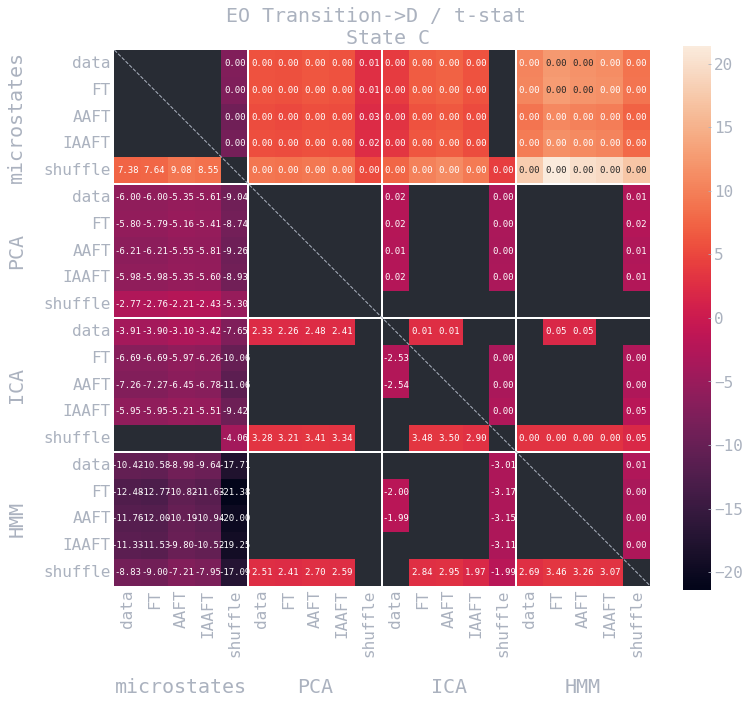

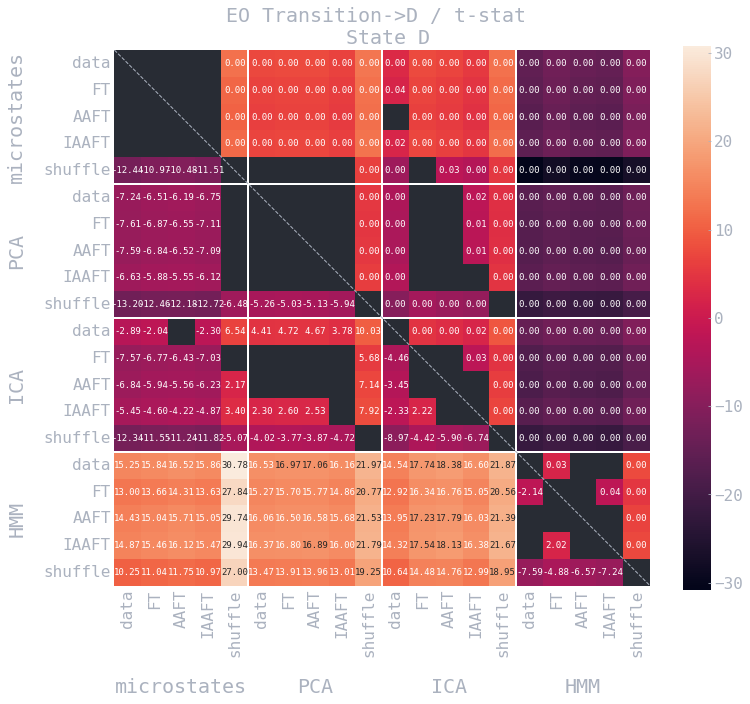

In [10]:
for k, var in enumerate(variables):
    for ms in range(len(state_names)):
        tit = f"EO {var.title()} / t-stat \n State {state_names[ms]}"
        plot_matrix_w_annot(
            t_stats_trans[k, ms, ...],
            annot=True,
            mask_pvals=True,
            title=tit,
        )